# **Problem 3: Adding Different Types of Degradations to Images**

In [29]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
from scipy.signal import convolve2d
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from numpy.fft import fft2, ifft2, fftshift
from scipy import ndimage

# A.

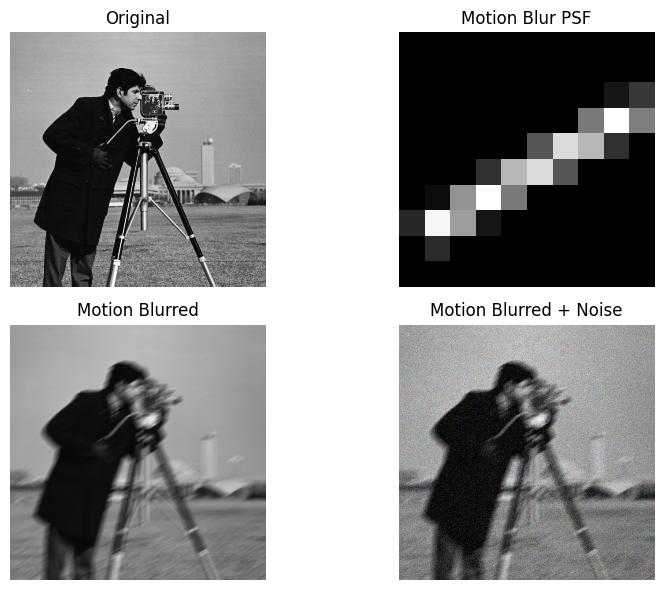

True

In [30]:
# Generate motion blur PSF with length L and angle theta
def generate_motion_blur_psf(L, theta_deg):
    size = L + 2  
    kernel = np.zeros((size, size), dtype=np.float32)
    center = size // 2
    start = center - L // 2
    end = start + L
    kernel[center, start:end] = 1.0 / L  

    # Rotate kernel with fixed size
    rotated = rotate(kernel, theta_deg, reshape=False, order=1, mode='nearest')
    rotated /= rotated.sum()

    start = (size - L) // 2
    end = start + L
    return rotated[start:end, start:end]


def apply_motion_blur(image, psf):
    if image.ndim == 3:  # Color image
        blurred = np.zeros_like(image, dtype=np.float32)
        for c in range(3):
            blurred[:, :, c] = convolve2d(image[:, :, c], psf, mode='same', boundary='symm')
    else:  # Grayscale image
        blurred = convolve2d(image, psf, mode='same', boundary='symm')
    return blurred

# Add Gaussian or Poisson noise to normalized image
def add_noise(image, noise_type='gaussian', mean=0, var=0.001):
    if noise_type == 'gaussian':
        noise = np.random.normal(mean, np.sqrt(var), image.shape)
        noisy = image + noise
    elif noise_type == 'poisson':
        noisy = np.random.poisson(image * 255) / 255.0
    else:
        raise ValueError("Unknown noise type: only 'gaussian' or 'poisson'")
    return np.clip(noisy, 0, 1)


image = cv2.imread('cameraman.png', cv2.IMREAD_COLOR)
if image is None:
    raise FileNotFoundError("Image 'cameraman.png' not found!")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image.astype(np.float32) / 255.0  

# Define motion blur parameters
L = 10
theta = 30

# Generate PSF and apply blur
psf = generate_motion_blur_psf(L, theta)
blurred_image = apply_motion_blur(image, psf)

# Add Gaussian noise
noisy_blurred_image = add_noise(blurred_image, noise_type='gaussian', var=0.002)

plt.figure(figsize=(9, 6))
plt.subplot(2, 2, 1)
plt.title("Original")
plt.imshow(image)
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title("Motion Blur PSF")
plt.imshow(psf, cmap='gray')  
plt.axis('off')

plt.subplot(2, 2, 3)
plt.title("Motion Blurred")
plt.imshow(np.clip(blurred_image, 0, 1))
plt.axis('off')

plt.subplot(2, 2, 4)
plt.title("Motion Blurred + Noise")
plt.imshow(noisy_blurred_image)
plt.axis('off')

plt.tight_layout()
plt.show()

cv2.imwrite("degraded_output.png", cv2.cvtColor((noisy_blurred_image * 255).astype(np.uint8), cv2.COLOR_RGB2BGR))

# Part B.

PSNR: 19.01 dB
SSIM: 0.2620


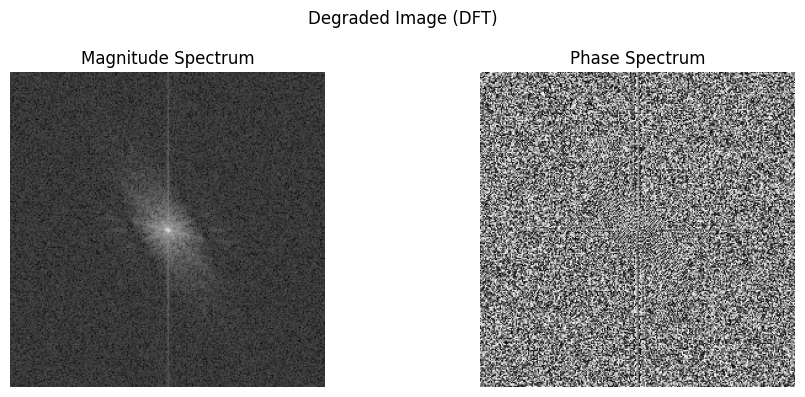

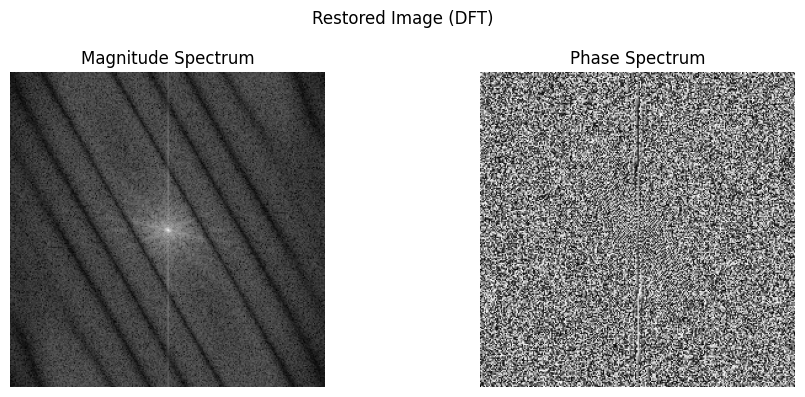

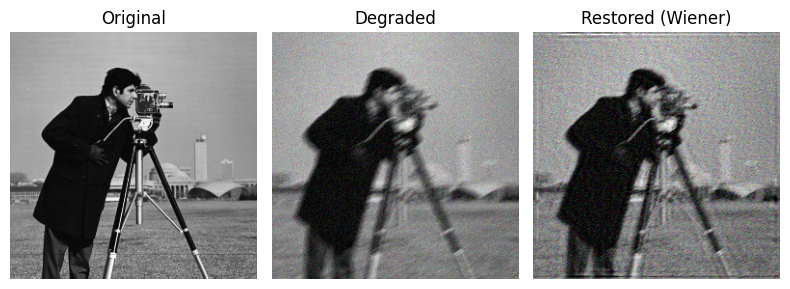

In [31]:
# Apply Wiener filter to restore degraded image
def wiener_filter(degraded, psf, K):
    eps = 1e-8
    psf_padded = np.zeros_like(degraded)
    psf_h, psf_w = psf.shape
    center = (degraded.shape[0]//2 - psf_h//2, degraded.shape[1]//2 - psf_w//2)
    psf_padded[center[0]:center[0]+psf_h, center[1]:center[1]+psf_w] = psf
    psf_padded = fftshift(psf_padded)

# Compute Fourier transforms and Wiener filter
    H = fft2(psf_padded)
    G = fft2(degraded)
    H_conj = np.conj(H)
    H_abs2 = np.abs(H) ** 2
    F_hat = (H_conj / (H_abs2 + K + eps)) * G
    restored = np.real(ifft2(F_hat))
    return np.clip(restored, 0, 1)

K = 0.05   # noise parameter

# Apply Wiener filter
if noisy_blurred_image.ndim == 3:
    restored = np.zeros_like(noisy_blurred_image)
    for c in range(3):
        restored[:, :, c] = wiener_filter(noisy_blurred_image[:, :, c], psf, K)
else:
    restored = wiener_filter(noisy_blurred_image, psf, K)

# Compute PSNR and SSIM metrics
if image.ndim == 3:
    psnr_value = psnr(image, restored, data_range=1.0)
    ssim_value = ssim(image, restored, data_range=1.0, channel_axis=-1)
else:
    psnr_value = psnr(image, restored, data_range=1.0)
    ssim_value = ssim(image, restored, data_range=1.0)

print(f"PSNR: {psnr_value:.2f} dB")
print(f"SSIM: {ssim_value:.4f}")

# Display DFT magnitude and phase of input image
def show_dft(image, title):
    f = fft2(image)
    fshift = fftshift(f)
    magnitude = np.log(1 + np.abs(fshift))
    phase = np.angle(fshift)

    plt.figure(figsize=(10, 4))
    plt.suptitle(title)
    plt.subplot(1, 2, 1)
    plt.title("Magnitude Spectrum")
    plt.imshow(magnitude, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Phase Spectrum")
    plt.imshow(phase, cmap='gray')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Select grayscale images for DFT visualization
gray_for_dft = noisy_blurred_image if noisy_blurred_image.ndim == 2 else noisy_blurred_image[:, :, 0]
restored_gray = restored if restored.ndim == 2 else restored[:, :, 0]

show_dft(gray_for_dft, "Degraded Image (DFT)")
show_dft(restored_gray, "Restored Image (DFT)")


plt.figure(figsize=(8, 4))
plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Degraded")
plt.imshow(noisy_blurred_image)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Restored (Wiener)")
plt.imshow(restored)
plt.axis('off')

plt.tight_layout()
plt.show()

# Part C.

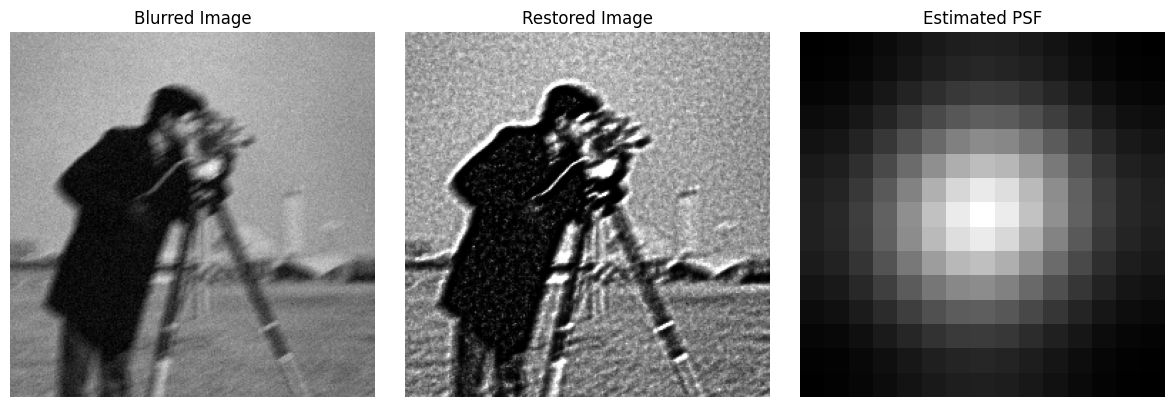

No true PSF available. Visual inspection suggests PSF estimation quality.


In [42]:
# Load the blurred image from part a
blurred_image = cv2.imread('degraded_output.png', cv2.IMREAD_GRAYSCALE)
if blurred_image is None:
    raise FileNotFoundError("Could not load 'degraded_output.png'. Check the file path!")
blurred_image = blurred_image.astype(np.float32) / 255.0

# Initialize PSF with a small delta function
def initialize_psf(size):
    psf = np.zeros((size, size), dtype=np.float32)
    center = size // 2
    psf[center, center] = 1.0
    return psf / psf.sum() 

# Blind deconvolution using Richardson-Lucy with PSF
def blind_richardson_lucy(blurred, psf_init, iterations=50, lambda_reg=0.01):
    image_est = np.copy(blurred) 
    psf_est = np.copy(psf_init)  
    psf_size = psf_est.shape[0]
    half_size = psf_size // 2
    h, w = blurred.shape
    
    for i in range(iterations):
        # Estimate image
        conv_image = convolve2d(image_est, psf_est, mode='same', boundary='symm')
        conv_image = np.clip(conv_image, 1e-10, None)  
        relative_blur = blurred / conv_image
        image_update = convolve2d(relative_blur, psf_est[::-1, ::-1], mode='same', boundary='symm')
        image_est *= image_update
        image_est = np.clip(image_est, 0, 1)

        conv_psf = convolve2d(image_est, psf_est, mode='same', boundary='symm')
        conv_psf = np.clip(conv_psf, 1e-10, None)
        relative_psf = blurred / conv_psf
        psf_update_full = convolve2d(relative_psf, image_est[::-1, ::-1], mode='same', boundary='symm')
        
        # Extract central part and apply regularization
        center_h, center_w = h // 2, w // 2
        psf_update = psf_update_full[center_h - half_size:center_h + half_size + 1,
                                     center_w - half_size:center_w + half_size + 1]
        psf_est *= psf_update
        psf_est /= psf_est.sum() + 1e-10  
        psf_est = np.clip(psf_est, 0, 1 - lambda_reg * i / iterations)  
        psf_est = cv2.GaussianBlur(psf_est, (3, 3), 0.5)
        psf_est /= psf_est.sum() + 1e-10

    return image_est, psf_est

# Compare estimated PSF with ground truth, if available
def evaluate_psf_accuracy(estimated_psf, true_psf=None):
    if true_psf is not None:
        ssim_score = ssim(estimated_psf, true_psf, data_range=1.0)
        print(f"SSIM between estimated and true PSF: {ssim_score:.4f}")
    else:
        print("No true PSF available. Visual inspection suggests PSF estimation quality.")

psf_initial = initialize_psf(size=15)
restored_image, estimated_psf = blind_richardson_lucy(blurred_image, psf_initial, iterations=50)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(blurred_image, cmap='gray')
plt.title('Blurred Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(restored_image, cmap='gray')
plt.title('Restored Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(estimated_psf, cmap='gray')
plt.title('Estimated PSF')
plt.axis('off')

plt.tight_layout()
plt.show()

evaluate_psf_accuracy(estimated_psf)

# Part D.

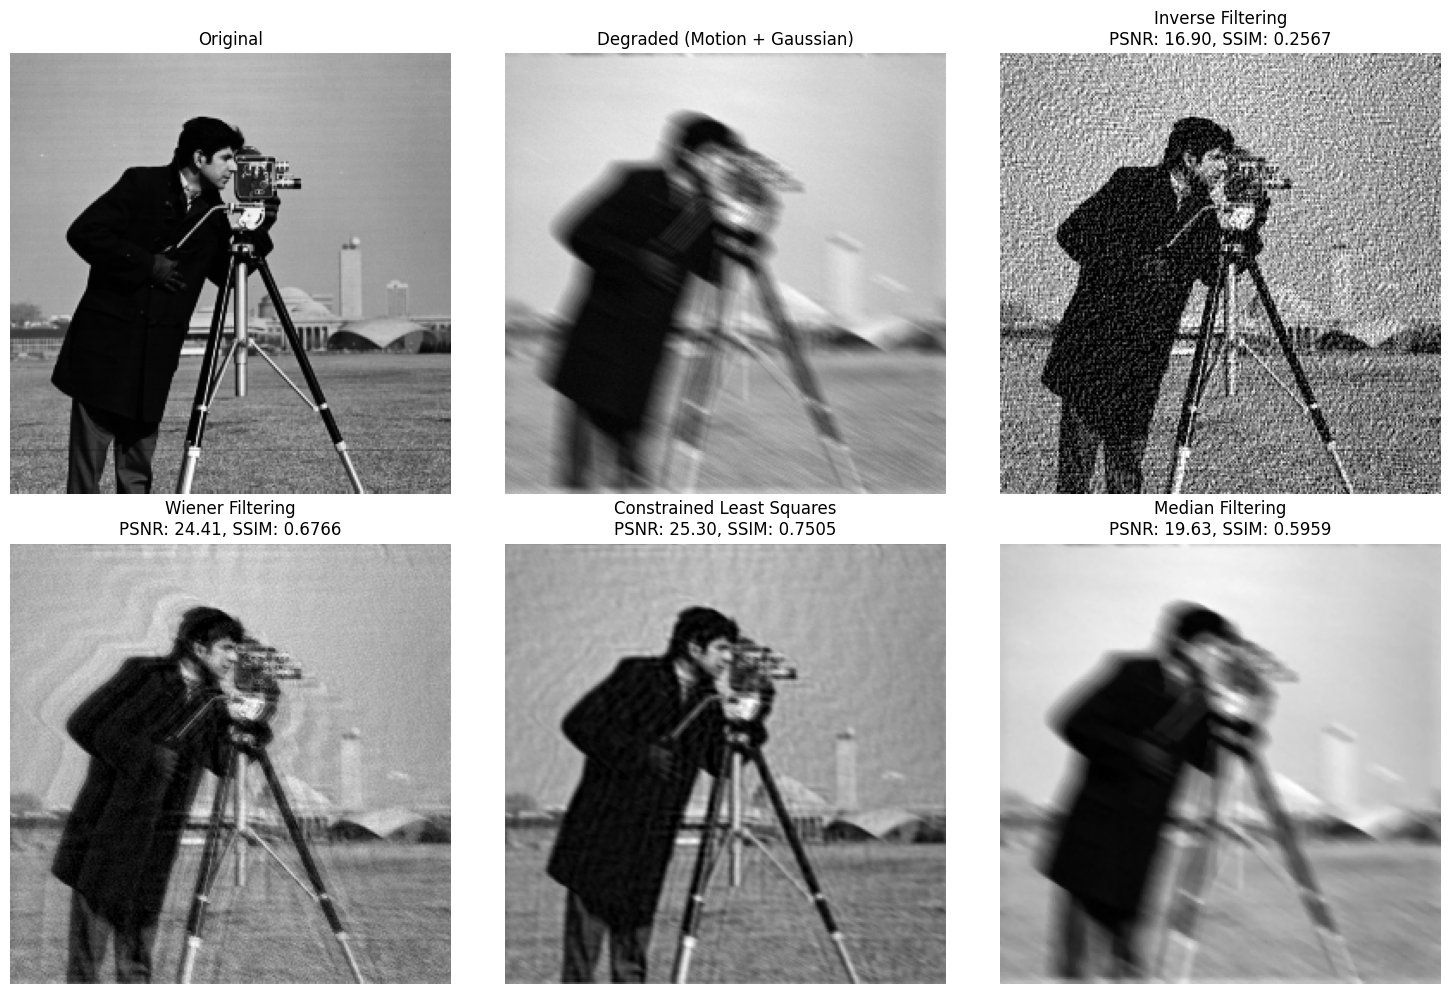

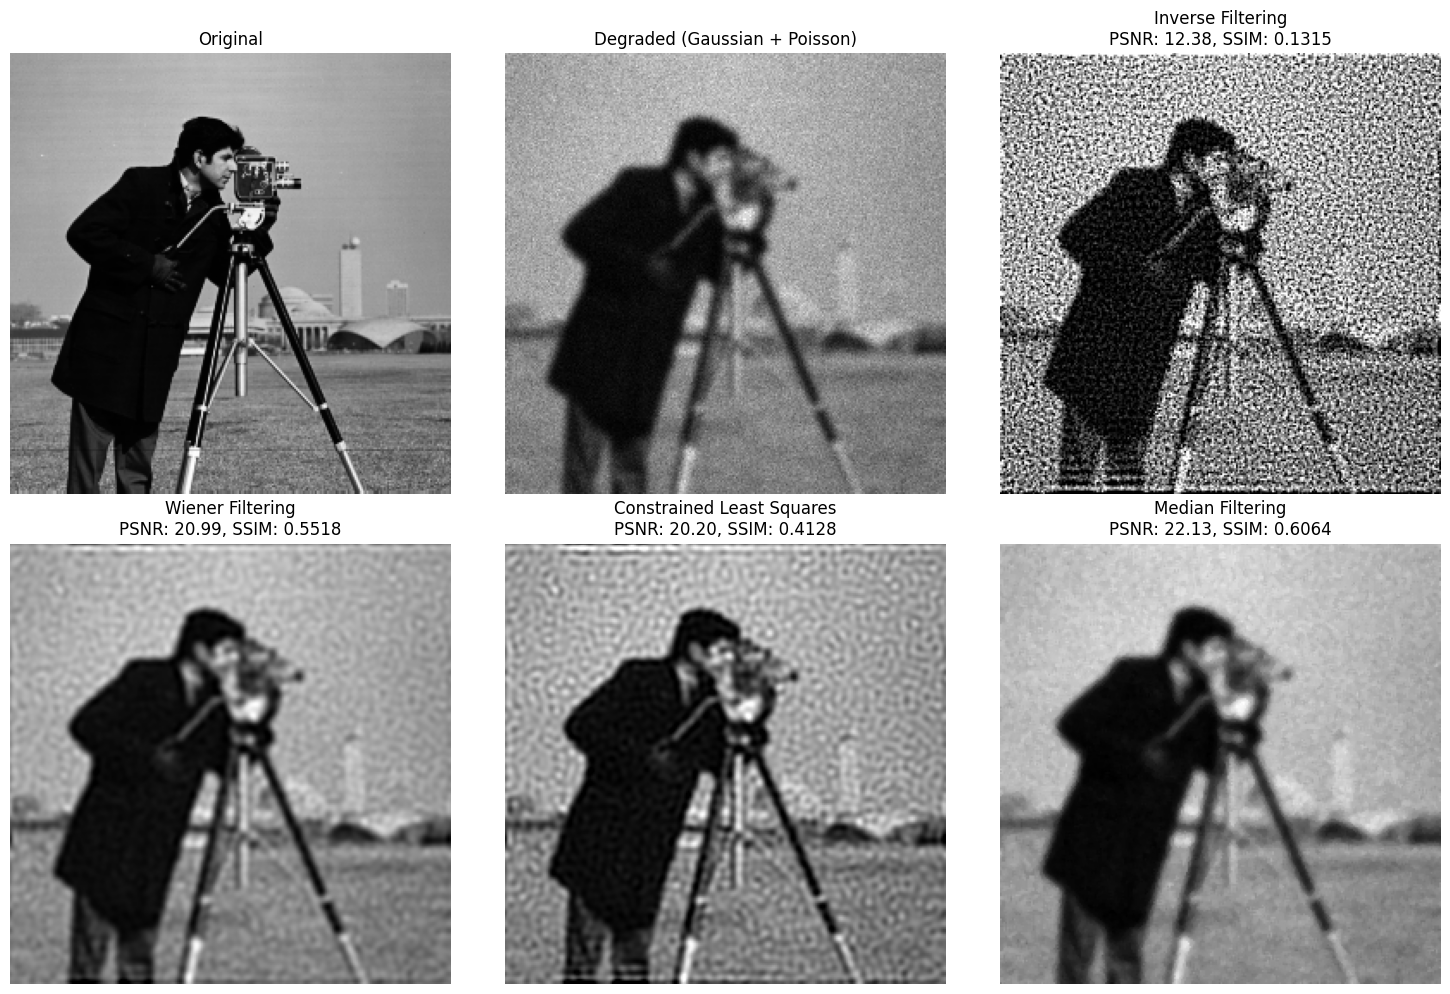

Scores for Motion Blur + Gaussian Noise:
                                PSNR      SSIM
Inverse Filtering          16.903953  0.256732
Wiener Filtering           24.410569  0.676639
Constrained Least Squares  25.301832  0.750466
Median Filtering           19.625906  0.595917

Scores for Gaussian Blur + Poisson Noise:
                                PSNR      SSIM
Inverse Filtering          12.384335  0.131497
Wiener Filtering           20.990797  0.551760
Constrained Least Squares  20.197886  0.412839
Median Filtering           22.127087  0.606401


In [ ]:
# Load and normalize grayscale image
image = cv2.imread('cameraman.png', cv2.IMREAD_GRAYSCALE)
if image is None:
    raise FileNotFoundError("Image 'cameraman.png' not found!")
image = image.astype(np.float32) / 255.0

# Generate motion blur PSF
def motion_blur_psf(length=15, angle=30):
    psf = np.zeros((length, length), dtype=np.float32)
    center = length // 2
    x = np.arange(length)
    y = np.tan(np.radians(angle)) * (x - center) + center
    for i in range(length):
        y_pos = int(round(y[i]))
        if 0 <= y_pos < length:
            psf[y_pos, i] = 1
    psf /= psf.sum()
    return psf

# Apply motion blur via FFT
def apply_motion_blur(image, psf):
    h, w = image.shape
    psf_padded = np.zeros((h, w), dtype=np.float32)
    ph, pw = psf.shape
    psf_padded[:ph, :pw] = psf
    psf_padded = np.roll(psf_padded, -ph//2, axis=0)
    psf_padded = np.roll(psf_padded, -pw//2, axis=1)
    H = fft2(psf_padded)
    G = fft2(image)
    blurred = np.real(ifft2(G * H))
    return np.clip(blurred, 0, 1)

# Apply Gaussian blur
def apply_gaussian_blur(image, sigma=2):
    return cv2.GaussianBlur(image, (0, 0), sigmaX=sigma)

# Preprocess to reduce initial noise
def preprocess_image(degraded, sigma=0.5):
    return cv2.GaussianBlur(degraded, (0, 0), sigmaX=sigma)

# Degrade with motion blur + Gaussian noise
psf_motion = motion_blur_psf(length=15, angle=30)
blurred_motion = apply_motion_blur(image, psf_motion)
noise_sigma = 0.005 
gaussian_noise = np.random.normal(0, noise_sigma, image.shape)
degraded_motion = np.clip(blurred_motion + gaussian_noise, 0, 1)

# Degrade with Gaussian blur + Poisson noise
blurred_gaussian = apply_gaussian_blur(image, sigma=2)
blurred_gaussian_scaled = np.clip(blurred_gaussian * 255, 0, 255).astype(np.uint8)
poisson_noise = np.random.poisson(blurred_gaussian_scaled).astype(np.float32) - blurred_gaussian_scaled.astype(np.float32)
degraded_gaussian = blurred_gaussian + (poisson_noise / 255.0)
degraded_gaussian = np.clip(degraded_gaussian, 0, 1)

# Inverse filter for restoration
def inverse_filter(degraded, psf, eps=1e-2):
    psf_padded = np.zeros_like(degraded)
    kh, kw = psf.shape
    psf_padded[:kh, :kw] = psf
    psf_padded = np.roll(psf_padded, -kh//2, axis=0)
    psf_padded = np.roll(psf_padded, -kw//2, axis=1)
    G = fft2(degraded)
    H = fft2(psf_padded)
    H_abs = np.abs(H)
    H[H_abs < eps] = eps
    F_hat = G / H
    return np.clip(np.real(ifft2(F_hat)), 0, 1)

# Wiener filter for restoration
def wiener_filter(degraded, psf, K=0.01):
    psf_padded = np.zeros_like(degraded)
    kh, kw = psf.shape
    psf_padded[:kh, :kw] = psf
    psf_padded = np.roll(psf_padded, -kh//2, axis=0)
    psf_padded = np.roll(psf_padded, -kw//2, axis=1)
    G = fft2(degraded)
    H = fft2(psf_padded)
    H_conj = np.conj(H)
    F_hat = (H_conj / (np.abs(H)**2 + K)) * G
    return np.clip(np.real(ifft2(F_hat)), 0, 1)

# Constrained Least Squares filtering using Laplacian prior
def constrained_least_squares_filter(degraded, psf, gamma=0.005):
    psf_padded = np.zeros_like(degraded)
    kh, kw = psf.shape
    psf_padded[:kh, :kw] = psf
    psf_padded = np.roll(psf_padded, -kh//2, axis=0)
    psf_padded = np.roll(psf_padded, -kw//2, axis=1)
    laplacian = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
    laplacian_padded = np.zeros_like(degraded)
    lh, lw = laplacian.shape
    laplacian_padded[:lh, :lw] = laplacian
    laplacian_padded = np.roll(laplacian_padded, -lh//2, axis=0)
    laplacian_padded = np.roll(laplacian_padded, -lw//2, axis=1)

    G = fft2(degraded)
    H = fft2(psf_padded)
    P = fft2(laplacian_padded)
    F_hat = (np.conj(H) / (np.abs(H)**2 + gamma * np.abs(P)**2)) * G
    return np.clip(np.real(ifft2(F_hat)), 0, 1)

# Median filter for restoration
def median_filter(degraded, size=3):
    return ndimage.median_filter(degraded, size=size)

# Motion blur + Gaussian noise restoration
restored_motion_inverse = inverse_filter(degraded_motion, psf_motion)
restored_motion_wiener = wiener_filter(degraded_motion, psf_motion, K=0.01)
restored_motion_cls = constrained_least_squares_filter(degraded_motion, psf_motion, gamma=0.005)
restored_motion_median = median_filter(degraded_motion, size=3)

# Gaussian blur + Poisson noise restoration
psf_gaussian_1d = cv2.getGaussianKernel(15, 2)
psf_gaussian = psf_gaussian_1d @ psf_gaussian_1d.T
psf_gaussian /= psf_gaussian.sum()
degraded_gaussian_pre = preprocess_image(degraded_gaussian, sigma=0.5)  
restored_gaussian_inverse = inverse_filter(degraded_gaussian_pre, psf_gaussian, eps=0.1)  
restored_gaussian_wiener = wiener_filter(degraded_gaussian_pre, psf_gaussian, K=0.05)  
restored_gaussian_cls = constrained_least_squares_filter(degraded_gaussian_pre, psf_gaussian, gamma=0.01)  # Adjusted gamma
restored_gaussian_median = median_filter(degraded_gaussian, size=3)

# Compute PSNR and SSIM
def get_scores(gt, img):
    return psnr(gt, img, data_range=1.0), ssim(gt, img, data_range=1.0)

methods = {
    "Inverse Filtering": (restored_motion_inverse, restored_gaussian_inverse),
    "Wiener Filtering": (restored_motion_wiener, restored_gaussian_wiener),
    "Constrained Least Squares": (restored_motion_cls, restored_gaussian_cls),
    "Median Filtering": (restored_motion_median, restored_gaussian_median)
}

scores_motion = {name: get_scores(image, res[0]) for name, res in methods.items()}
scores_gaussian = {name: get_scores(image, res[1]) for name, res in methods.items()}

# Motion blur degradation
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.ravel()
axs[0].imshow(image, cmap='gray')
axs[0].set_title("Original")
axs[1].imshow(degraded_motion, cmap='gray')
axs[1].set_title("Degraded (Motion + Gaussian)")

for i, (name, res) in enumerate(methods.items(), start=2):
    p, s = scores_motion[name]
    axs[i].imshow(res[0], cmap='gray')
    axs[i].set_title(f"{name}\nPSNR: {p:.2f}, SSIM: {s:.4f}")

for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.savefig('motion_restoration_comparison.png')
plt.show()

# Gaussian blur degradation
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.ravel()
axs[0].imshow(image, cmap='gray')
axs[0].set_title("Original")
axs[1].imshow(degraded_gaussian, cmap='gray')
axs[1].set_title("Degraded (Gaussian + Poisson)")

for i, (name, res) in enumerate(methods.items(), start=2):
    p, s = scores_gaussian[name]
    axs[i].imshow(res[1], cmap='gray')
    axs[i].set_title(f"{name}\nPSNR: {p:.2f}, SSIM: {s:.4f}")

for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()

df_motion = pd.DataFrame(scores_motion).T.rename(columns={0: 'PSNR', 1: 'SSIM'})
df_gaussian = pd.DataFrame(scores_gaussian).T.rename(columns={0: 'PSNR', 1: 'SSIM'})
print("Scores for Motion Blur + Gaussian Noise:")
print(df_motion)
print("\nScores for Gaussian Blur + Poisson Noise:")
print(df_gaussian)

# Part E.

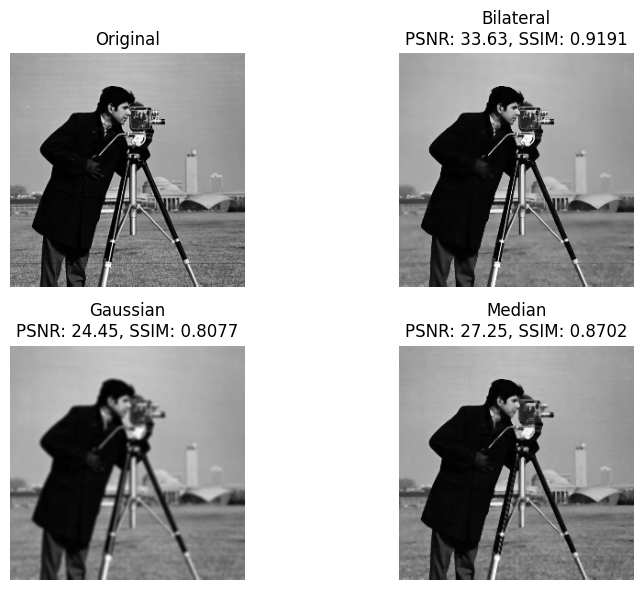

Results:
Bilateral Filter: PSNR = 33.63, SSIM = 0.9191
Gaussian Filter: PSNR = 24.45, SSIM = 0.8077
Median Filter: PSNR = 27.25, SSIM = 0.8702


In [ ]:
# Add Gaussian noise to image
noise_std = 0.01  
noisy_image = np.clip(image + np.random.normal(0, noise_std, image.shape), 0, 1)

def bilateral_filter_fast(img, diameter=5, sigma_color=0.1, sigma_space=2.0):
    half = diameter // 2
    padded_img = np.pad(img, ((half, half), (half, half)), mode='reflect')
    H, W = img.shape
    
    # Compute fixed spatial Gaussian weights
    ax = np.arange(-half, half+1)
    xx, yy = np.meshgrid(ax, ax)
    spatial_weight = np.exp(-(xx**2 + yy**2) / (2 * sigma_space**2))
    
    filtered_img = np.zeros_like(img)
    
    for i in range(H):
        for j in range(W):
            local_patch = padded_img[i:i+diameter, j:j+diameter]
            color_diff = local_patch - img[i, j]
            color_weight = np.exp(-(color_diff**2) / (2 * sigma_color**2))
            
            # Combine and normalize weights
            weights = spatial_weight * color_weight
            weights /= weights.sum()
            
            # Compute filtered pixel
            filtered_img[i, j] = np.sum(weights * local_patch)
    return filtered_img

# Apply Gaussian blur
def gaussian_filter_cv(img, ksize=5, sigma=1.5):
    return cv2.GaussianBlur(img, (ksize, ksize), sigma)

# Apply Median blur
def median_filter_cv(img, ksize=3):
    img_uint8 = np.uint8(img * 255)
    filtered = cv2.medianBlur(img_uint8, ksize)
    return filtered.astype(np.float32) / 255.0

# Apply filters
bilateral_result = bilateral_filter_fast(noisy_image, diameter=5, sigma_color=0.1, sigma_space=2.0)
gaussian_result = gaussian_filter_cv(noisy_image, ksize=5, sigma=1.5)
median_result = median_filter_cv(noisy_image, ksize=3)

# Compute PSNR and SSIM metrics
psnr_bilateral = psnr(image, bilateral_result, data_range=1.0)
ssim_bilateral = ssim(image, bilateral_result, data_range=1.0)
psnr_gaussian = psnr(image, gaussian_result, data_range=1.0)
ssim_gaussian = ssim(image, gaussian_result, data_range=1.0)
psnr_median = psnr(image, median_result, data_range=1.0)
ssim_median = ssim(image, median_result, data_range=1.0)


plt.figure(figsize=(9, 6))
plt.subplot(2, 2, 1)
plt.title('Original')
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title(f'Bilateral\nPSNR: {psnr_bilateral:.2f}, SSIM: {ssim_bilateral:.4f}')
plt.imshow(bilateral_result, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.title(f'Gaussian\nPSNR: {psnr_gaussian:.2f}, SSIM: {ssim_gaussian:.4f}')
plt.imshow(gaussian_result, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.title(f'Median\nPSNR: {psnr_median:.2f}, SSIM: {ssim_median:.4f}')
plt.imshow(median_result, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

# Print numerical results
print("Results:")
print(f"Bilateral Filter: PSNR = {psnr_bilateral:.2f}, SSIM = {ssim_bilateral:.4f}")
print(f"Gaussian Filter: PSNR = {psnr_gaussian:.2f}, SSIM = {ssim_gaussian:.4f}")
print(f"Median Filter: PSNR = {psnr_median:.2f}, SSIM = {ssim_median:.4f}")

# Part F.